Basic Hartmann Optimization - Showing Inconsistency

In [1]:
import torch
from botorch.test_functions import Hartmann
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement, qUpperConfidenceBound, qExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import InputStandardize, Normalize
import numpy as np
import random
from tqdm.auto import trange
import warnings
from typing import List

from botorch.exceptions.warnings import InputDataWarning, BadInitialCandidatesWarning

# Filter out some annoying automatic botorch warnings
warnings.filterwarnings("ignore", category=InputDataWarning)
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)

from matplotlib import pyplot as plt
from cycler import cycler
# make some nice looking plots
plt.style.use("ggplot")
palette = ["#00B0F6", "#F8766D", "#00BF7D", "#A3A500", "#E76BF3"]
# palette = ["#122746ff", "#b28e5dff", "#8b9499ff", "#f05022ff"]
plt.rc('axes', prop_cycle=(cycler('color', palette)))


c:\Users\stan\miniconda3\envs\research\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seeds(seed=42):
    """set all library random seeds"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def random_sampler(n=2, dims=3):
    """Randomly sample the design space."""
    sample = torch.rand(n, dims, dtype=torch.float64)
    return sample


def random_restarts(gp, X, y, num_restarts=5):
    _seed_list = [4295, 8508, 326, 3135, 1549, 2528, 1274, 6545, 5971, 6269, 2422, 4287]
    mlls = []
    losses = torch.zeros(num_restarts)
    for i in range(num_restarts):
        set_seeds(_seed_list[i])
        gp = SingleTaskGP(
            train_X=X,
            train_Y=y,
            # input_transform = InputStandardize(d=X.shape[-1]), # standardize X
            input_transform = Normalize(d=X.shape[-1]), # standardize X
            outcome_transform = Standardize(m=y.shape[-1]), # standardize y
        )
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        mll = fit_gpytorch_mll(mll)
        losses[i] = -mll(gp.forward(X), y).mean().item()
        mlls.append(mll)
    
    best = torch.argmin(losses)
    print(losses)
    return mlls[best]

In [3]:
# list of seeds to use for each run
seed_list = [4295, 8508, 326, 3135, 1549, 2528, 1274, 6545, 5971, 6269, 2422, 4287, 9320, 4932, 951, 4304, 1745, 5956, 7620, 4545, 6003, 9885, 5548, 9477, 30, 8992, 7559, 5034, 9071, 6437, 3389, 9816, 8617, 3712, 3626, 1660, 3309, 2427, 9872, 938, 5156, 7409, 7672, 3411, 3559, 9966, 7331, 8273, 8484, 5127, 2260, 6054, 5205, 311, 6056, 9456, 928, 6424, 7438, 8701, 8634, 4002, 6634, 8102, 8503, 1540, 9254, 7972, 7737, 3410, 4052, 8640, 9659, 8093, 7076, 7268, 2046, 7492, 3103, 3034, 7874, 5438, 4297, 291, 5436, 9021, 3711, 7837, 9188, 2036, 8013, 6188, 3734, 187, 1438, 1061, 674, 777, 7231, 7096, 3360, 4278, 5817, 5514, 3442, 6805, 6750, 8548, 9751, 3526, 9969, 8979, 1526, 1551, 2058, 6325, 1237, 5917, 5821, 9946, 5049, 654, 7750, 5149, 3545, 9165, 2837, 5621, 6501, 595, 3181, 1747, 4405, 4480, 4282, 9262, 6219, 3960, 4999, 1495, 6007, 9642, 3902, 3133, 1085, 3278, 1104, 5939, 7153, 971, 8733, 3785, 9056, 2020, 7249, 5021, 3384, 8740, 4593, 7869, 9941, 8813, 3688, 8139, 6436, 3742, 5503, 1587, 4766, 9846, 9117, 7001, 4853, 9346, 4927, 8480, 5298, 4753, 1151, 9768, 5405, 6196, 5721, 3419, 8090, 8166, 7834, 1480, 1150, 9002, 1134, 2237, 3995, 2029, 5336, 7050, 6857, 8794, 1754, 1184, 3558, 658, 6804, 8750, 5088, 1136, 626, 8462, 5203, 3196, 979, 7419, 1162, 5451, 6492, 1562, 8145, 8937, 8764, 4174, 7639, 8902, 7003, 765, 1554, 6135, 1689, 9530, 1398, 2273, 7925, 5948, 1036, 868, 4617, 1203, 7680, 7, 93, 3128, 5694, 6979, 7136, 8084, 5770, 9301, 1599, 737, 7018, 3774, 9843, 2296, 2287, 9875, 2349, 2469, 8941, 4973, 3798, 54, 2938, 4665, 3942, 3951, 9400, 3094, 2248, 3376, 1926, 5180, 1773, 3681, 1808, 350, 6669, 826, 539, 5313, 6193, 5752, 9370, 2782, 8399, 4881, 3166, 4906, 5829, 4827, 29, 6899, 9012, 6986, 4175, 1035, 8320, 7802, 3777, 6340, 7798, 7705]
ensemble_count = 3 # how many complete optimization loops to run
n_init = 3 # how many samples to start with
budget = 27 # how many optimization iterations to perform per loop

nr = 20
nrs = 250

ensemble_best_to_trial = []
ensemble_X = []
ensemble_y = []
# enseble_acqf = []
# ensemmble_params=[]

set_seeds(10) # keep constant seed for out-of-loop initialization
hart = Hartmann(dim=6, bounds=[(0,1)]*6, negate=True)

X_ = random_sampler(n=n_init, dims=6)
y_ = hart(X=X_[:,:])[:,None]

for i in (pbar0 := trange(ensemble_count, leave=True, colour="red")):
    # acqf = []
    # params = []
    set_seeds(seed_list[i]) # set random seeds for optimizers
    X = X_.clone()
    y = y_.clone()
    for j in (pbar1 := trange(budget, leave=True)):

        # build the gp model
        gp = SingleTaskGP(
            train_X=X,
            train_Y=y,
            input_transform = Normalize(d=X.shape[-1]), # standardize X
            outcome_transform = Standardize(m=y.shape[-1]), # standardize y
        )

        # fit the model by maximizing the likelihood.
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        mll = fit_gpytorch_mll(mll)

        # set bounds for acqf
        bounds = torch.stack([torch.zeros(6), torch.ones(6)])

        # print(f"{j} best_to_trial", best_to_trial[-1])
        # print(f"{j} best_y", torch.max(y))
        # sobolsampler = SobolQMCNormalSampler(sample_shape=torch.Size([1024]), seed=0)
        X_new, acq_value = optimize_acqf(
            # acq_function= qUpperConfidenceBound(gp, beta=2, sampler=sobolsampler),
            acq_function = UpperConfidenceBound(gp, beta=2),
            # acq_function = ExpectedImprovement(gp, best_f=torch.max(y)),
            bounds=bounds,
            q=1, # how many new points to generate
            num_restarts = nr, # how many times to restart the optimizer
            raw_samples = nrs # how many initial points to sample acqf space from
        )

        X = torch.cat([X, X_new])
        y = torch.cat([y, hart(X=X_new)[:,None]])

        pbar0.set_description(f"Processing Trial {j+1} of Loop {i+1}")
        pbar1.set_description(f"Loop {i+1} | Best Value {round(torch.max(y).item(),3)}")

    best_to_trial = torch.zeros_like(y)
    for i in range(len(best_to_trial)):
        best_to_trial[i] = torch.max(y.flatten()[:i+1]).item()

    ensemble_best_to_trial.append(best_to_trial.flatten().numpy())

    ensemble_y.append(y.flatten().numpy())

Loop 1 | Best Value 3.309: 100%|██████████| 27/27 [00:10<00:00,  2.59it/s]/s]
Loop 2 | Best Value 3.301: 100%|██████████| 27/27 [00:09<00:00,  2.95it/s] 10.41s/it]
Loop 3 | Best Value 3.072: 100%|██████████| 27/27 [00:10<00:00,  2.46it/s]  9.68s/it]
Processing Trial 27 of Loop 3: 100%|██████████| 3/3 [00:30<00:00, 10.18s/it]


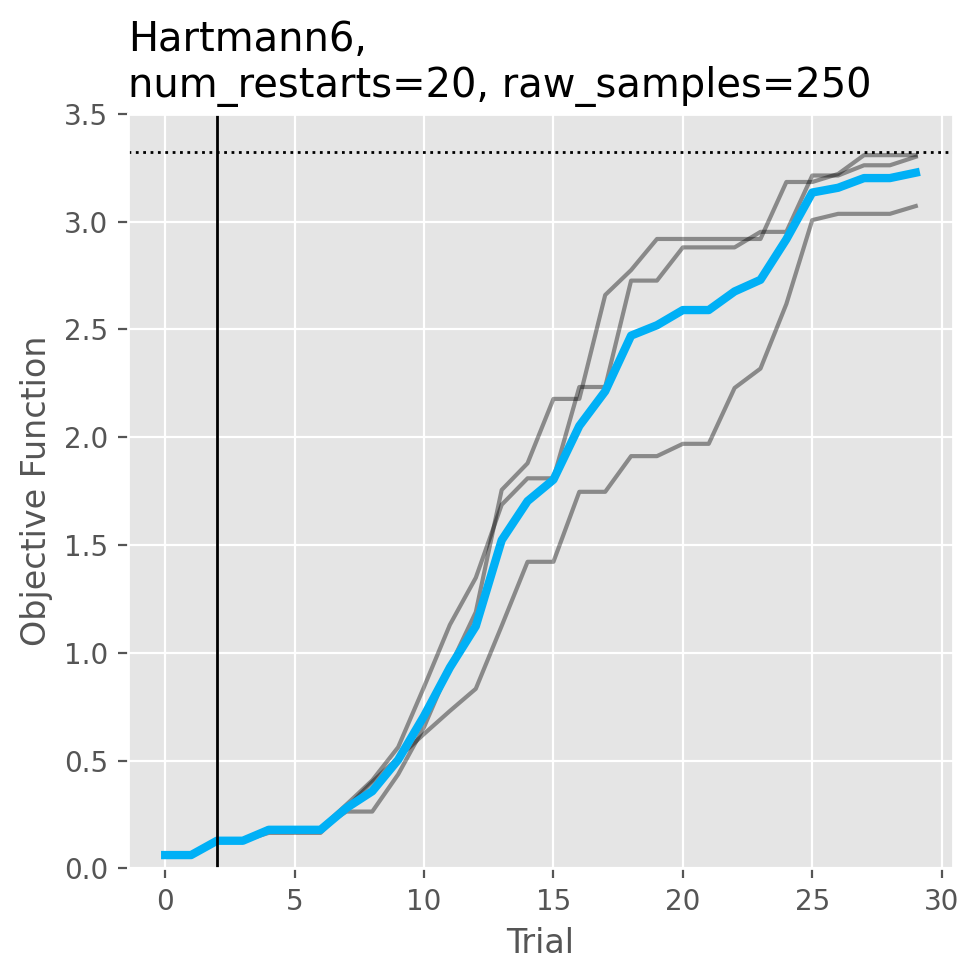

In [4]:
fig, ax = plt.subplots(nrows=1, layout='tight', figsize=(5,5), dpi=200)
fig.align_ylabels() 

for trace in ensemble_best_to_trial:
    ax.plot(trace, c='k', lw=1.5, alpha=0.4)
ax.plot(np.mean(np.stack(ensemble_best_to_trial), axis=0),lw=3, label="Mean", color=palette[0])
# ax.plot(pd.read_csv("seed_aggregates/20_500_50_best_to_trial.csv",index_col=0), lw=3, color=palette[1])
ax.plot([],[], c='k', lw=1.5, alpha=0.35, label='Trace$_i$')
ax.set_ylabel("Objective Function")
ax.set_xlabel("Trial")
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.title(f"Hartmann6,\nnum_restarts={nr}, raw_samples={nrs}", loc='left')
plt.ylim(0, 3.5)
plt.axvline(n_init-1, ls='-', lw=1, color='k')
plt.axhline(3.32237, ls=':', lw=1, color='k')
# plt.text(1, 1.08, "Fixed Points", ha='center', rotation=90)
plt.show()